In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid96263/


In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

import pyccl as ccl
import pymaster as nmt
import healpy as hp

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = os.path.join(os.path.dirname(os.environ['SCRATCH']), 
                    'share/raytracesim/HSC_S16A/mocks_4zbins')

In [4]:
i = 25
rot = 9
sims = [os.path.join(path, sim) for sim in os.listdir(path) if f'r{i:03d}_rot{rot:02d}' in sim]

In [5]:
sim_dict = {}
for i, sim in enumerate(sims):
    # Remove objects with z = -1
    sim = fits.open(sim)[1].data
    sim = sim[sim['z_source_mock'] != -1]

    # Get z centers and boundary
    z = np.unique(sim['z_source_mock'])
    z_edges = 0.5 * (z[1:] + z[:-1])
    z_edges = np.concatenate([[0], z_edges, [np.max(z)+0.2]])
    dNdz, _ = np.histogram(sim['z_source_mock'], bins=z_edges, density=True)
    sim_dict[i] = {
        'z': z,
        'dNdz': dNdz,
        'ra': sim['ra_mock'],
        'dec': sim['dec_mock'],
        'e1': sim['e1_mock'],
        'e2': sim['e2_mock'],
        'g1': sim['shear1_sim'],
        'g2': sim['shear2_sim']
    }

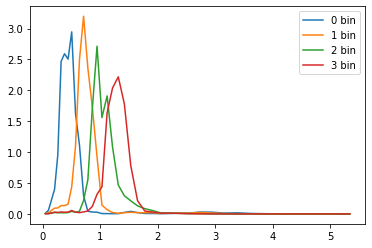

In [6]:
for b in sim_dict.keys():
    sim = sim_dict[b]
    plt.plot(sim['z'], sim['dNdz'], label=f'{b} bin')
plt.legend()

In [7]:
nside = 512
npix = hp.nside2npix(nside)
cosmo = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, n_s=0.97, sigma8=0.82)
ell = np.arange(3 * nside)

tracers = [ccl.WeakLensingTracer(cosmo, (sim_dict[i]['z'], sim_dict[i]['dNdz'])) for i in range(len(sim_dict.keys()))]

In [8]:
cl_ccl = ccl.cls.angular_cl(cosmo, tracers[0], tracers[0], ell)
cls_ee=cl_ccl*1.
cls_bb=cl_ccl*0.
cls_et=cl_ccl
cls_eb=cl_ccl*0
cls_tb=cl_ccl*0
cl_maps = hp.sphtfunc.synfast([
    cl_ccl, cls_ee, cls_bb, cls_et, cls_eb, cls_tb], nside, new=True, pol=True)

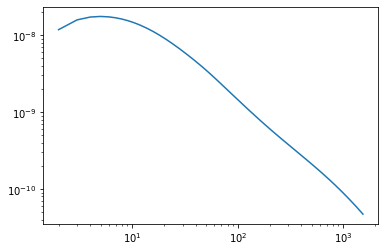

In [9]:
plt.loglog(ell[2:], cl_ccl[2:])

In [10]:
def plot_mollview(cl_maps):
    for i in range(cl_maps.shape[0]):
        hp.mollview(cl_maps[i])

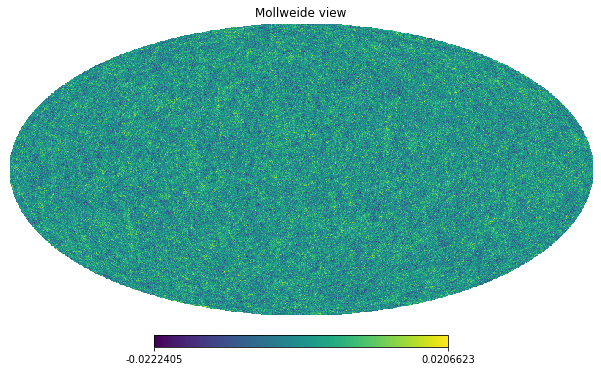

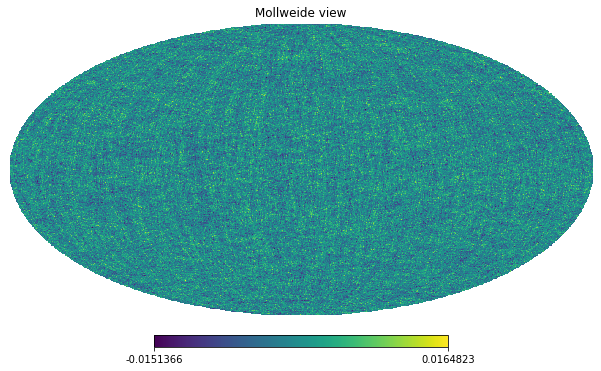

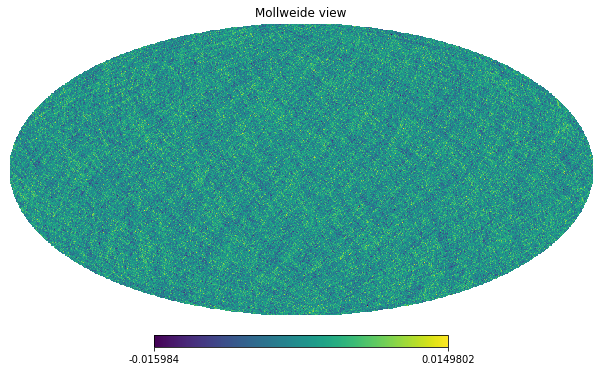

In [11]:
plot_mollview(cl_maps)

In [12]:
f_sky = 0.01
mask = np.zeros_like(cl_maps[0], dtype='bool')
mask[:int(npix//(1/f_sky))] = 1

cl_maps_masked = cl_maps * 1
cl_maps_masked[:, ~mask] = hp.UNSEEN

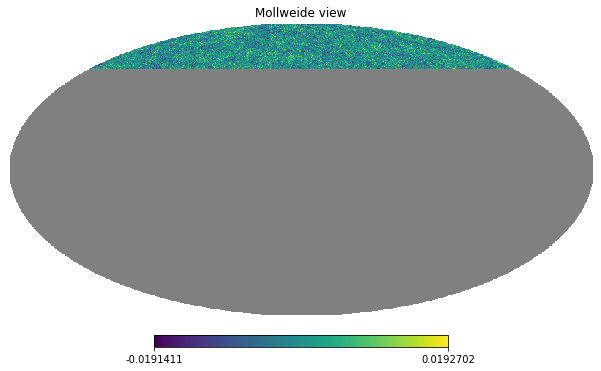

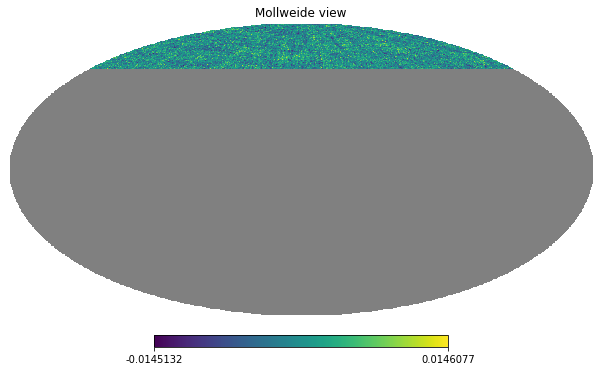

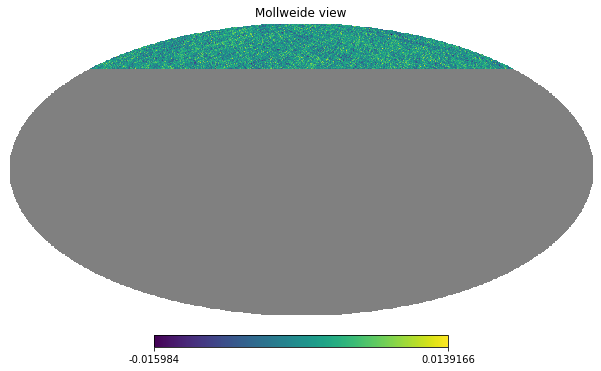

In [13]:
plot_mollview(cl_maps_masked)

# NaMaster

In [14]:
delta_map, gamma1_map, gamma2_map = cl_maps_masked

In [15]:
f_2 = nmt.NmtField(mask, [gamma1_map, gamma2_map])
b = nmt.NmtBin.from_nside_linear(nside, 1)
ell_arr = b.get_effective_ells()

In [16]:
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f_2, f_2, b)

In [17]:
Dl_nmt = nmt.compute_coupled_cell(f_2, f_2)
Dl_hp = hp.anafast([delta_map, gamma1_map, gamma2_map], pol=True)

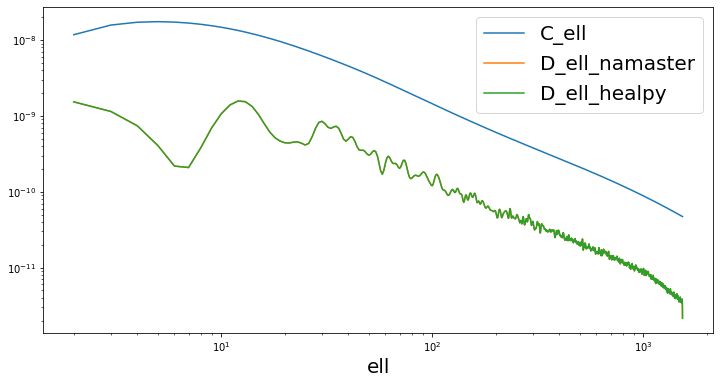

In [18]:
plt.figure(figsize=(12, 6))
plt.loglog(ell_arr, cl_ccl[2:], label='C_ell')
plt.loglog(ell_arr, Dl_nmt[0][2:], label='D_ell_namaster')
plt.loglog(ell_arr, Dl_hp[1][2:], label='D_ell_healpy')
plt.xlabel('ell', fontsize=20)
plt.legend(fontsize=20);

# noise = sigma_e ** 2 / n_eff / f_sky

In [19]:
use_window=True
unit_window=False

do_pseudo_cl=True
do_xi=False

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

In [20]:
shear_zbins=lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=f_sky,unit_win=unit_window)

ns0:  27.0
[0.10002001 0.10082017 0.10162032 ... 2.9981997  2.9989998  2.9998    ] 100 5
source_tomo_bins, zmax 5.0 2.9998 0.59997
Tracer utils has no tracers
skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'tracer_utils': None, 'shear_zbins': None, 'kappa_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684739047072, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[

scatter_dict got empty dictionary
cl_tomo, Win: None
cl graph done
gather_dict got empty dictionary


In [21]:
shear_zbins[0]['z'] = sim['z']
shear_zbins[0]['dz'] = np.gradient(sim['z'])
shear_zbins[0]['pz'] = sim['dNdz']
shear_zbins[0]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])

In [22]:
shear_zbins[0]['window'] = mask
shear_zbins[0]['window_N'] = mask

In [23]:
#setup parameters
lmax_cl = 3 * nside - 1 #2000
lmin_cl = 0

l0 = np.arange(lmin_cl,lmax_cl)

window_lmax= lmax_cl

lmin_cl_Bins = 10 #lmin_cl+2
lmax_cl_Bins = lmax_cl-10
Nl_bins = 10

# l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=1)#,binning_mode='decreasing')
# l_bins=l_bins[l_bins<=lmax_cl_Bins]
# l_bins0=l_bins*1.
l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
dl=(l_bins[1:]-l_bins[:-1])
lb_cl=lb*1.
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [24]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
SL_cl0=Skylens(**Skylens_kwargs)

skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'use_defaults': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684739047072, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)}, 'WT_kwargs': None, 'WT': None, 'z_PS': None, 'log_z_PS': 2, 'window_l': None, 'Win': None, 'cl_func_names': {('galaxy', 'gal

In [25]:
clG = SL_cl0.cl_tomo()
cl0 = client.compute(clG['cl_b']).result()
pcl_b = client.compute(clG['pseudo_cl_b']).result()

pcl0 = client.compute(clG['stack']).result()

scatter_dict got empty dictionary
cl_tomo, Win: {'cl': {('shear', 'shear'): {(0, 0): <Future: finished, type: dict, key: (0, 0)>}}}
cl graph done
gather_dict got empty dictionary


In [26]:
clG.keys()

dict_keys(['stack', 'cl_b', 'cl', 'pseudo_cl', 'pseudo_cl_b', 'zkernel'])

In [27]:
SL_cl0.gather_data()

gather_dict got empty dictionary


In [28]:
DL_binned = SL_cl0.binning.bin_1d(Dl_hp[1, :-1],bin_utils=SL_cl0.cl_bin_utils)
cls_ee_binned = SL_cl0.binning.bin_1d(cls_ee[:-1],bin_utils=SL_cl0.cl_bin_utils)
wt0 = 1./cls_ee[:-1]
wt0[:2] = 0
M_binned = SL_cl0.binning.bin_2d_coupling(M=SL_cl0.Win['cl'][corr_ll][bi]['M'],wt0=wt0,
                                    wt_b=cls_ee_binned,bin_utils=SL_cl0.cl_bin_utils)
bc = (SL_cl0.l_bins[1:]+SL_cl0.l_bins[:-1])*.5

#         cl_sl = Dl_hp[1, :-1] @ np.linalg.pinv(SL.Win['cl'][corr_ll][bi]['M']) 
cl_sl =  Dl_hp[1, :-1] @ np.linalg.pinv(SL_cl0.Win['cl'][corr_ll][bi]['M'])
cl_sl_binned =  DL_binned @ np.linalg.inv(M_binned)

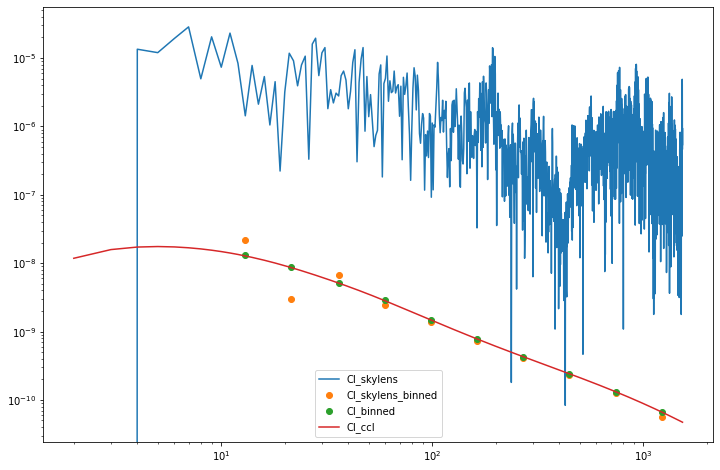

done combine lm 0.46418166160583496
stack got 2pt


In [41]:
plt.figure(figsize=(12, 8))
plt.loglog(ell_arr, np.abs(cl_sl[:-1]), label='Cl_skylens')
plt.loglog(bc, np.abs(cl_sl_binned),'o', label='Cl_skylens_binned')
plt.loglog(bc, cls_ee_binned,'o', label='Cl_binned')
plt.loglog(ell_arr, cl_ccl[2:], label='Cl_ccl')
plt.legend();

In [30]:
def study_geometry(nside=128, nlb=1, f_sky=0.5):
    ell = np.arange(3 * nside)
    npix = hp.nside2npix(nside)
    
    cl_ccl = ccl.cls.angular_cl(cosmo, tracers[0], tracers[0], ell)
    cl = cl_ccl * 1
    cls_ee=cl_ccl*1.
    cls_bb=cl_ccl*0.
    cls_et=cl_ccl
    cls_eb=cl_ccl*0
    cls_tb=cl_ccl*0
    cl_maps = hp.sphtfunc.synfast([
        cl_ccl, cls_ee, cls_bb, cls_et, cls_eb, cls_tb], nside, new=True, pol=True)
    
    mask = np.zeros_like(cl_maps[0], dtype='bool')
    mask[:int(npix//(1/f_sky))] = 1

    cl_maps_masked = cl_maps * 1
    cl_maps_masked[:, ~mask] = hp.UNSEEN
    
    plot_mollview(cl_maps_masked)
    
    density_map, gamma1_map, gamma2_map = cl_maps_masked

    Dl_hp = hp.anafast([delta_map, gamma1_map, gamma2_map], pol=True)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
    
    axs[0].loglog(ell_arr, cl_ccl[2:], label='C_ell')
    axs[0].loglog(ell_arr, Dl_hp[1][2:], label='D_ell_healpy')
    axs[0].set_xlabel('ell', fontsize=15)
    axs[0].legend(fontsize=15)
    
    # Skylens params
    use_window=True
    unit_window=False

    do_pseudo_cl=True
    do_xi=False

    bin_cl=True
    bin_xi=True

    use_binned_l=False
    use_binned_theta=False

    store_win=True
    
    #setup parameters
    lmax_cl = 3 * nside - 1 #2000
    lmin_cl = 0

    l0 = np.arange(lmin_cl,lmax_cl)

    window_lmax= lmax_cl

    lmin_cl_Bins = 10 #lmin_cl+2
    lmax_cl_Bins = lmax_cl-10
    Nl_bins = 10

    # l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=1)#,binning_mode='decreasing')
    # l_bins=l_bins[l_bins<=lmax_cl_Bins]
    # l_bins0=l_bins*1.
    l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
    lb=.5*(l_bins[1:]+l_bins[:-1])
    dl=(l_bins[1:]-l_bins[:-1])
    lb_cl=lb*1.
    l_bins_center=lb*1
    Nl_bins=len(lb)

    # l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
    l=l0
    
    shear_zbins = lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=f_sky,unit_win=unit_window)
    shear_zbins[0]['z'] = sim['z']
    shear_zbins[0]['dz'] = np.gradient(sim['z'])
    shear_zbins[0]['pz'] = sim['dNdz']
    shear_zbins[0]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])

    shear_zbins[0]['window'] = mask
    shear_zbins[0]['window_N'] = mask
    
    Skylens_kwargs=parse_dict(locals())

    Skylens_kwargs['do_pseudo_cl'] = True
    Skylens_kwargs['do_xi'] = False
    SL = Skylens(**Skylens_kwargs)
    
    print('passed')
    
    clG = SL.cl_tomo()
    cl0 = client.compute(clG['cl_b']).result()
    pcl_b = client.compute(clG['pseudo_cl_b']).result()

    pcl0 = client.compute(clG['stack']).result()
    
    SL.gather_data()
    
    DL_binned = SL.binning.bin_1d(Dl_hp[1, :-1],bin_utils=SL.cl_bin_utils)
    cls_ee_binned = SL.binning.bin_1d(cls_ee[:-1],bin_utils=SL.cl_bin_utils)
    wt0 = 1./cls_ee[:-1]
    wt0[:2] = 0
    M_binned = SL.binning.bin_2d_coupling(M=SL.Win['cl'][corr_ll][bi]['M'],wt0=wt0,
                                        wt_b=cls_ee_binned,bin_utils=SL.cl_bin_utils)
    bc = (SL.l_bins[1:]+SL.l_bins[:-1])*.5
    
#         cl_sl = Dl_hp[1, :-1] @ np.linalg.pinv(SL.Win['cl'][corr_ll][bi]['M']) 
    cl_sl =  Dl_hp[1, :-1] @ np.linalg.pinv(SL.Win['cl'][corr_ll][bi]['M'])
    cl_sl_binned =  DL_binned @ np.linalg.inv(M_binned)
    axs[1].loglog(ell_arr, np.abs(cl_sl[:-1]), label='Cl_skylens')
    axs[1].loglog(bc, np.abs(cl_sl_binned),'o', label='Cl_skylens_binned')
    axs[1].loglog(bc, cls_ee_binned,'o', label='Cl_binned')
        
    axs[1].legend()

In [31]:
M = SL_cl0.Win['cl'][corr_ll][bi]['M']
Mi = np.linalg.pinv(M)

In [32]:
np.diag(Mi@M)

array([0.        , 0.        , 0.77699053, ..., 0.9106822 , 1.0227498 ,
       1.0098008 ], dtype=float32)

In [33]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


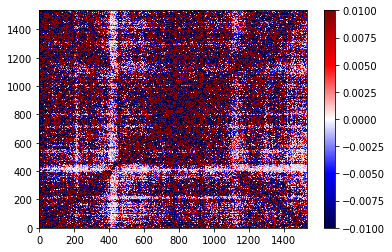

In [34]:
pcolor(Mi@M -  np.eye(len(M)),cmap='seismic',vmax=.01,vmin=-.01)
colorbar()

In [35]:
from matplotlib.colors import LogNorm

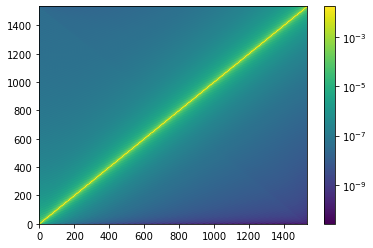

In [36]:
pcolor(M,norm=LogNorm())
colorbar()

In [37]:
def study_geometry(nside=128, nlb=1, f_sky=0.5, SL=None):
    ell = np.arange(3 * nside)
    npix = hp.nside2npix(nside)
    cl_ccl = ccl.cls.angular_cl(cosmo, tracers[0], tracers[0], ell)
    cl = cl_ccl * 1
    cls_ee=cl_ccl*1.
    cls_bb=cl_ccl*0.
    cls_et=cl_ccl
    cls_eb=cl_ccl*0
    cls_tb=cl_ccl*0
    cl_maps = hp.sphtfunc.synfast([
        cl_ccl, cls_ee, cls_bb, cls_et, cls_eb, cls_tb], nside, new=True, pol=True)
    
    if len(cl_maps) != 3:
        print('cl_maps must be TEQ')
        return
    
    mask = np.zeros_like(cl_maps[0], dtype='bool')
    mask[:int(npix//(1/f_sky))] = 1

    cl_maps_masked = cl_maps * 1
    cl_maps_masked[:, ~mask] = hp.UNSEEN
    
    plot_mollview(cl_maps_masked)
    
    density_map, gamma1_map, gamma2_map = cl_maps_masked
    f_2 = nmt.NmtField(mask, [gamma1_map, gamma2_map])
    b = nmt.NmtBin.from_nside_linear(nside, nlb)
    ell_arr = b.get_effective_ells()
    
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f_2, f_2, b)
    
    Dl_nmt = nmt.compute_coupled_cell(f_2, f_2)
    Dl_hp = hp.anafast([delta_map, gamma1_map, gamma2_map], pol=True)
    
    cl_bias = nmt.deprojection_bias(f_2, f_2, [cl, cl, cl, cl])
    
    cl_nmt = w.decouple_cell(Dl_nmt, cl_bias)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
    
    axs[0, 0].loglog(ell_arr, cl_ccl[2:], label='C_ell')
    axs[0, 0].loglog(ell_arr, Dl_nmt[0][2:], label='D_ell_namaster')
    axs[0, 0].loglog(ell_arr, Dl_hp[1][2:], label='D_ell_healpy')
    axs[0, 0].set_xlabel('ell', fontsize=15)
    axs[0, 0].legend(fontsize=15);
    
    axs[0, 1].plot(ell_arr, Dl_nmt[0][2:] / cl_ccl[2:], label='D_ell_namaster')
    axs[0, 1].plot(ell_arr, Dl_hp[1][2:] / cl_ccl[2:], label='D_ell_healpy')
    axs[0, 1].set_xscale('log')
    axs[0, 1].set_ylabel('D_ell / C_ell', fontsize=15)
    axs[0, 1].set_xlabel('ell', fontsize=15)
    axs[0, 1].legend(fontsize=15);

    axs[1, 0].plot(ell_arr, 1 - Dl_nmt[0][2:] / Dl_hp[1][2:])
    axs[1, 0].set_xscale('log')
    axs[1, 0].set_ylabel('1 - D_ell_namaster / D_ell_hp', fontsize=15)
    axs[1, 0].set_xlabel('ell', fontsize=15)
    
    axs[1, 1].loglog(ell_arr, cl_ccl[2:], label='true Cl')
    axs[1, 1].loglog(ell_arr, np.abs(cl_nmt[0]), label='Cl_namaster')
    axs[1, 1].set_xlabel('ell', fontsize=15)
    axs[1, 1].set_ylabel('C_ell', fontsize=15)
    DL_binned=SL.binning.bin_1d(Dl_hp[1, :-1],bin_utils=SL.cl_bin_utils)
    cls_ee_binned=SL.binning.bin_1d(cls_ee[:-1],bin_utils=SL.cl_bin_utils)
    wt0=1./cls_ee[:-1]
    wt0[:2]=0
    M_binned=SL.binning.bin_2d_coupling(M=SL.Win['cl'][corr_ll][bi]['M'],wt0=wt0,
                                        wt_b=cls_ee_binned,bin_utils=SL.cl_bin_utils)
    bc=(SL.l_bins[1:]+SL.l_bins[:-1])*.5
    if SL is not None:
#         cl_sl = Dl_hp[1, :-1] @ np.linalg.pinv(SL.Win['cl'][corr_ll][bi]['M']) 
        cl_sl =  Dl_hp[1, :-1]@np.linalg.pinv(SL.Win['cl'][corr_ll][bi]['M'])
        cl_sl_binned =  DL_binned@np.linalg.inv(M_binned)
        axs[1, 1].loglog(ell_arr, np.abs(cl_sl[:-1]), label='Cl_skylens')
        axs[1, 1].loglog(bc, np.abs(cl_sl_binned),'o', label='Cl_skylens_binned')
        axs[1, 1].loglog(bc, cls_ee_binned,'o', label='Cl_binned')
        
    axs[1, 1].legend()